## Import necessary python libraries

In [1]:
import feyn
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
import warnings
warnings.filterwarnings('ignore')
import collections
import os

In [2]:
from functions import *

In [3]:
feyn.__version__

'2.1.2'

In [4]:
projectname = 'insulin_response_'
pathname = '../figures/'

## Load necessary files

In [5]:
expression_table = '../data/insulin_dataset.csv'
data_togo = pd.read_csv(expression_table, sep=',')
data_togo["patient_number"] = np.floor(np.array(data_togo.index)/2)
data_togo["patient_number"] = data_togo["patient_number"].astype(int)
target = "Class_"

In [6]:
data_togo.head()

,Cond,7SK,A1BG,A2M,A2M-AS1,A4GALT,AAAS,AACS,AADAC,AADAT,...,ZZEF1,ZZZ3,hsa-mir-1199,hsa-mir-3180-3,hsa-mir-3180-4,hsa-mir-6080,hsa-mir-8072,Class_,CV_Split,patient_number
0,NG1f0,61.707,0.869,22.325312,5.504,1.3035,26.7975,6.373,77.641,1.3035,...,27.232,11.0085,1.5930,1.4490,0.869,1.738,2.028,0.0,0.0,0
1,NG1h0,67.008,1.600,29.549125,4.621,2.7550,22.2175,43.013,57.232,3.7325,...,29.149,13.0635,2.0440,2.0440,0.711,0.889,2.488,1.0,0.0,0
2,NG2f0,37.882,3.164,20.439625,7.035,23.3330,28.9115,19.316,51.453,1.7900,...,57.489,10.6155,6.6395,11.3650,7.576,1.499,1.957,0.0,1.0,1
3,NG2h0,75.477,2.901,16.411500,6.017,24.4965,30.2445,20.091,62.101,1.4775,...,58.394,11.2005,5.6140,8.5955,4.029,1.558,1.826,1.0,1.0,1
4,NG3f0,131.061,8.107,13.412812,16.214,43.6870,28.3740,3.828,0.000,1.0135,...,47.515,4.5040,6.3055,3.7155,1.126,0.901,3.828,0.0,2.0,2


In [7]:
# make dictionary to store original features names
features_dict = dict()
for genes_names in data_togo.columns:
    qlattice_gene_names = genes_names.replace(".", "_").replace(".", "_")
    features_dict[qlattice_gene_names] = genes_names

## Standardise feature names

In [8]:
data_togo.columns = data_togo.columns.str.replace(".", "_")
data_togo.columns = data_togo.columns.str.replace("-", "_")

## Training a QLattice in a cross-validation scheme as framework


In [9]:
logdir='../models_insulin_paper/'
os.makedirs(logdir, exist_ok=True)


partitions_interval = np.arange(5)
inner_partitions_interval = partitions_interval#[partitions_interval != 4]

results = ModelResults()

all_fold_models = []


for val_partition in inner_partitions_interval:
    os.makedirs('%spartition_%i' % (logdir, val_partition), exist_ok=True)
    model_file = "%spartition_%i/model" % (logdir, val_partition)
    train = data_togo.loc[(data_togo.CV_Split != val_partition)]
    val = data_togo.loc[(data_togo.CV_Split == val_partition)]
    
    # Connecting to the QLattice
    
    ql = feyn.connect_qlattice()

    # Setting a seed
    
    ql.reset(random_seed=42)  

    stypes = dict()
    for f in train.columns:
        if train[f].dtype =='object':
            stypes[f] = 'c'
            
    models_ = ql.auto_run(data=train,
                          output_name="Class_",
                          kind="classification",
                          n_epochs=50,
                          max_complexity=5,
                          stypes=stypes,
                          criterion="bic",
                 )
    
    all_fold_models.append(models_)
    
    for j in models_:
        results.update(train, val, val_partition, j)
    
    for i in range(len(models_)):    
        models_[i].save(model_file+'_'+str(val_partition)+'_'+str(i)+'.json')
        
    

In [10]:
np.mean(results.df.groupby("fold").first().roc_auc_val), np.mean(results.df.roc_auc_val)

(0.9630872814609077, 0.9593907579599887)

In [11]:
np.std(results.df.groupby("fold").first().roc_auc_val), np.std(results.df.roc_auc_val)

(0.027323312638892466, 0.042159232975399724)

In [12]:
feat_list = list()
for j in np.arange(5):
    for i in range(len(all_fold_models[j])):
        genes = all_fold_models[j][i].features
        for gene in genes:
            if gene in features_dict.keys():
                feat_list.append(features_dict[gene])
            
count_features = collections.Counter(feat_list)
count_features_df = pd.DataFrame(count_features.items(),columns=['Gene', 'Count']).sort_values('Count', ascending=False)

### Compare with differential gene expression

In [13]:
de = pd.read_csv("../data/obesity_delist.csv")
de = de[de["FDR"]<0.05].sort_values(by="FDR")
de["de_position"] = np.arange(len(de))

In [14]:
compare_df = pd.merge(count_features_df.reset_index(drop=True), 
                      de[['gene', 'de_position', 'FDR']].groupby(['gene']).first(), 
                      left_on='Gene', right_on='gene', how="left")

In [15]:
compare_df.head(20)

,Gene,Count,de_position,FDR
0,PHF23,23,260.0,1.108311e-03
1,CDKN1A,15,75.0,1.184669e-05
2,SPRY4,5,33.0,1.547777e-06
3,PDK4,4,64.0,7.824044e-06
4,BHLHE41,4,166.0,1.615806e-04
5,CBX4,4,652.0,3.450078e-02
6,HEXIM1,3,253.0,9.501134e-04
7,PPP1R3B,2,1.0,3.011504e-13
8,CEBPD,2,648.0,3.424161e-02
9,C19orf80,2,0.0,1.022526e-15


## Training a QLattice in train-test split mode for final model choice



In [16]:
logdir='../models_insulin_paper_train_test/'
os.makedirs(logdir, exist_ok=True)

results_train_test = ModelResults()
os.makedirs('%spartition_%i' % (logdir, 1), exist_ok=True)
model_file = "%spartition_%i/model" % (logdir, 1)
train = data_togo.loc[(data_togo.CV_Split != 1)]
test = data_togo.loc[(data_togo.CV_Split == 1)]

# Connecting to the QLattice

ql = feyn.connect_qlattice()

# Setting a seed

ql.reset(random_seed=42)  

stypes = dict()
for f in train.columns:
    if train[f].dtype =='object':
        stypes[f] = 'c'

models_ = ql.auto_run(data=train,
                      output_name="Class_",
                      kind="classification",
                      n_epochs=50,
                      max_complexity=5,
                      stypes=stypes,
                      criterion="bic",
             )

#for j in models_:
#    results_train_test.update(train, test, 1, j)

#for i in range(len(models_)):    
#    models_[i].save(model_file+'_'+str(1)+'_'+str(i)+'.json')

In [17]:
df_summary = modsum(models_, train, test)[['N. Features', 'Functional form', 'BIC', 'Loss', 'AUC Train']]
df_summary

,N. Features,Functional form,BIC,Loss,AUC Train
0,3,logreg(CPT1B*PHF23 + TECTB),16.93,0.012366,1.0
1,3,logreg(CATG000000841241 + EXOC7 + PHF23),20.18,0.047962,1.0
2,3,logreg(HCN4*(PHF23 + ZNF621)),23.81,0.043090,1.0
3,3,logreg(PHF23*(CTD3162L105 + PDK4)),29.14,0.066883,1.0
4,2,logreg(SPRY4 + tanh(PDK4)),29.32,0.088783,1.0
5,2,logreg(PDK4 + SPRY4),30.59,0.115509,0.99
6,3,logreg(CDKN1A + PHF23 + SLA),32.97,0.105064,0.99
7,3,logreg(CDKN1A + EEF2K + TRMT13),33.75,0.108549,0.99
8,3,logreg(LDLR + PMFBP1 + SREBF1),35.37,0.115791,0.99
9,3,logreg(AREG + CTB55O610 + PHF23),36.93,0.122742,0.99


In [18]:
print(df_summary.to_latex())

\begin{tabular}{lrllrl}
\toprule
{} &  N. Features &                           Functional form &    BIC &      Loss & AUC Train \\
\midrule
0 &            3 &               logreg(CPT1B*PHF23 + TECTB) &  16.93 &  0.012366 &       1.0 \\
1 &            3 &  logreg(CATG000000841241 + EXOC7 + PHF23) &  20.18 &  0.047962 &       1.0 \\
2 &            3 &             logreg(HCN4*(PHF23 + ZNF621)) &  23.81 &  0.043090 &       1.0 \\
3 &            3 &        logreg(PHF23*(CTD3162L105 + PDK4)) &  29.14 &  0.066883 &       1.0 \\
4 &            2 &                logreg(SPRY4 + tanh(PDK4)) &  29.32 &  0.088783 &       1.0 \\
5 &            2 &                      logreg(PDK4 + SPRY4) &  30.59 &  0.115509 &      0.99 \\
6 &            3 &              logreg(CDKN1A + PHF23 + SLA) &  32.97 &  0.105064 &      0.99 \\
7 &            3 &           logreg(CDKN1A + EEF2K + TRMT13) &  33.75 &  0.108549 &      0.99 \\
8 &            3 &            logreg(LDLR + PMFBP1 + SREBF1) &  35.37 &  0.115791 & 

In [19]:
model = models_[1]

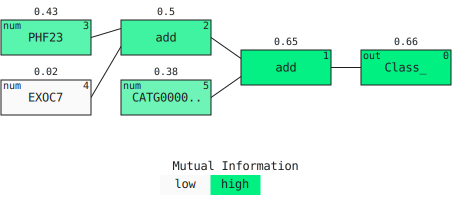

In [20]:
model.plot_signal(train, corr_func='mutual_information', 
                             filename=pathname+projectname+'plot_signal_mi.svg')

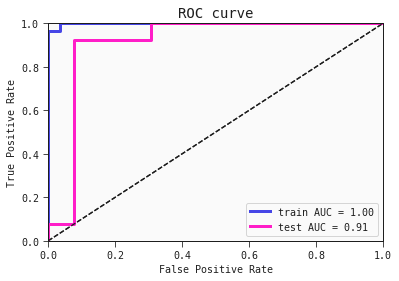

In [21]:
model.plot_roc_curve(train, label='train')
model.plot_roc_curve(test, label='test', ax=plt.gca())
plt.savefig(pathname+projectname+'roc_auc'+'.pdf', dpi=300, bbox_inches='tight')

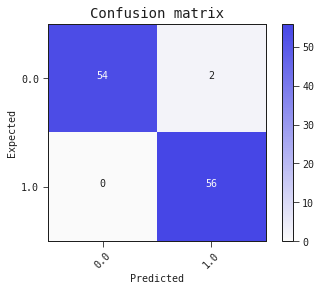

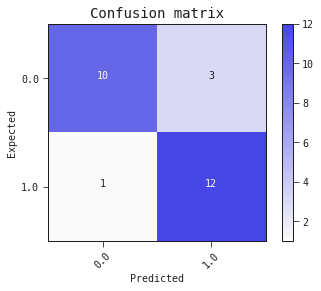

In [22]:
model.plot_confusion_matrix(train, filename=pathname+projectname+'confusion_train'+'.pdf')
model.plot_confusion_matrix(test, filename=pathname+projectname+'confusion_test'+'.pdf')

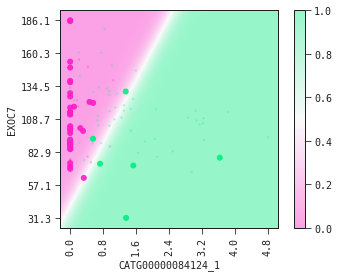

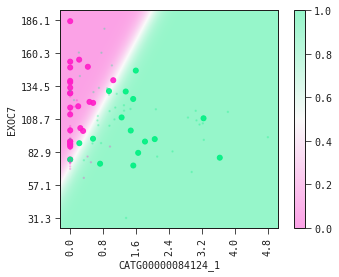

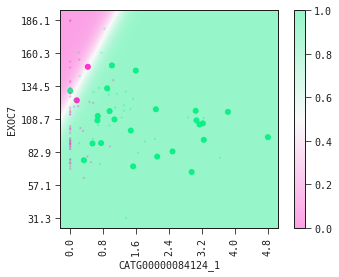

In [23]:
model.plot_response_2d(train[model.inputs + ['Class_']], fixed={"PHF23":train.PHF23.quantile(0.25)})
model.plot_response_2d(train[model.inputs + ['Class_']], fixed={"PHF23":train.PHF23.quantile(0.50)})
model.plot_response_2d(train[model.inputs + ['Class_']], fixed={"PHF23":train.PHF23.quantile(0.75)})

In [24]:
model.plot_response_2d(train[model.inputs + ['Class_']],fixed={"C2CD2L":train.C2CD2L.quantile(0.25)})
plt.title(label="C2CD2L quantile 0.25")
plt.tight_layout()
plt.savefig(pathname+projectname+"response2d_25.pdf", bbox_inches='tight')

ValueError: Fixed contains a name that is not an input to the model

In [ ]:
model.plot_response_2d(train[model.inputs + ['Class_']], fixed={"C2CD2L":train.C2CD2L.quantile(0.50)})
plt.title(label="C2CD2L quantile 0.50")
plt.tight_layout()
plt.savefig(pathname+projectname+"response2d_50.pdf")

In [ ]:
model.plot_response_2d(train[model.inputs + ['Class_']], fixed={"C2CD2L":train.C2CD2L.quantile(0.75)})
plt.title(label="C2CD2L quantile 0.75")
plt.tight_layout()
plt.savefig(pathname+projectname+"response2d_75.pdf")

In [ ]:
train.C2CD2L.quantile(0.25)

In [ ]:
train.C2CD2L.hist()

In [ ]:
print(model.sympify())

In [ ]:
#sns.displot(-0.104333*train[train['Class_']==0]['PDK4'] + 0.868373*train[train['Class_']==0]['PHF23'], kde=True)
sns.displot(train[["PDK4", "Class_"]],x="PDK4", hue="Class_", kde=True, bins=20,)
plt.savefig(pathname+projectname+"distPDK4.pdf")
sns.displot(train[["PHF23", "Class_"]],x="PHF23", hue="Class_", kde=True, bins=20)
plt.savefig(pathname+projectname+"distPHF23.pdf")
sns.displot(train[["C2CD2L", "Class_"]],x="C2CD2L", hue="Class_", kde=True, bins=20)
plt.savefig(pathname+projectname+"distC2CD2L.pdf")
sns.displot(train[["linear_combination", "Class_"]],x="linear_combination", hue="Class_", kde=True, bins=20)
plt.savefig(pathname+projectname+"distLC.pdf")

In [ ]:
train['linear_combination'] = -0.104333*train['PDK4'] + 0.868373*train['PHF23'] -1.09552*train['C2CD2']

In [ ]:
sns.pairplot(train[list(['PDK4', 'PHF23']) + ['Class_']], hue = 'Class_')

In [ ]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = epochs,
                                     criterion=criterion,
                                     max_complexity = max_complexity)

## Benchmarks

In [25]:
from sklearn.model_selection import GroupKFold

In [26]:
class InsulinKfold(GroupKFold):
    def __init__(self, n_splits=5):
        super().__init__(n_splits)
        
    def split(self, X, y=None, groups=None):
        return super().split(X, y=None, groups=X['patient_number'])

### LASSO

In [27]:
results_lasso = lasso_benchmark(data_togo, target, num_experiments=1, n_jobs=50, 
                                inner_cv=InsulinKfold(), outer_cv=InsulinKfold())

In [28]:
results_lasso

array([0.99479167, 0.97435897, 0.94871795, 0.95721925, 0.99375   ])

In [29]:
np.mean(results_lasso)

0.9737675682160976

### Random forest

#### No feature selection

In [30]:
results_rf = random_forest_benchmark(data_togo, target, n_jobs=50, inner_cv=InsulinKfold(), outer_cv=InsulinKfold())

In [31]:
results_rf

array([1.        , 0.98461538, 0.92820513, 0.89304813, 0.98125   ])

In [32]:
results_rf.mean()

0.9574237282325517

#### Feature selection by mutual information

In [ ]:
results_rf_mi = random_forest_benchmark(data_togo, target, feat_selection='mi', n_jobs=50, 
                                        inner_cv=InsulinKfold(), outer_cv=InsulinKfold())

In [ ]:
results_rf_mi

In [ ]:
results_rf_mi.mean()

#### Feature selection by f_score

In [ ]:
results_rf_f = random_forest_benchmark(data_togo, target, feat_selection='f_score', n_jobs=50,
                                       inner_cv=InsulinKfold(), outer_cv=InsulinKfold())

In [ ]:
results_rf_f

In [ ]:
results_rf_f.mean()

#### Feature selection by lasso

In [ ]:
results_rf_l = random_forest_benchmark(data_togo, target, feat_selection='lasso', n_jobs=50,
                                       inner_cv=InsulinKfold(), outer_cv=InsulinKfold())

In [ ]:
results_rf_l

In [ ]:
results_rf_l.mean()

### Gradient Boosting

#### No feature selection

In [ ]:
results_gb = gradient_boosting_benchmark(data_togo, target, inner_cv=InsulinKfold(), outer_cv=InsulinKfold())

In [ ]:
results_gb

In [ ]:
results_gb.mean()

#### Feature selection by mutual information

In [ ]:
results_gb_mi = gradient_boosting_benchmark(data_togo, target, feat_selection='mi', n_jobs=50,
                                            inner_cv=InsulinKfold(), outer_cv=InsulinKfold())

In [ ]:
results_gb_mi

In [ ]:
results_gb_mi.mean()

#### Feature selection by f_score

In [ ]:
results_gb_f = gradient_boosting_benchmark(data_togo, target, feat_selection='f_score', n_jobs=50, 
                                           inner_cv=InsulinKfold(), outer_cv=InsulinKfold())

In [ ]:
results_gb_f

In [ ]:
results_gb_f.mean()

#### Feature selection by lasso

In [ ]:
results_gb_l = gradient_boosting_benchmark(data_togo, target, feat_selection='lasso', n_jobs=50, 
                                           inner_cv=InsulinKfold(), outer_cv=InsulinKfold())

In [ ]:
results_gb_l

In [ ]:
results_gb_l.mean()

### Elastic net

In [ ]:
results_en = elasticnet_benchmark(data_togo, target, num_experiments=1,
                                  inner_cv=InsulinKfold(), outer_cv=InsulinKfold())

In [ ]:
results_en

In [ ]:
np.mean(results_en)

## Summary table

In [ ]:
data = [[results.groupby("fold").first().roc_auc_val.mean(), None, None, None],
        [np.mean(results_lasso), None, None, None],
        [np.mean(results_en), None, None, None],
        [np.mean(results_rf), np.mean(results_rf_mi), np.mean(results_rf_f), np.mean(results_rf_l)],
        [np.mean(results_gb), np.mean(results_gb_mi), np.mean(results_gb_f), np.mean(results_gb_l)]
       ]
df_bench = pd.DataFrame(data=data,
             index=["QLattice", "LASSO", "Elasticnet", "Random Forest", "Gradient Boosting"],
             columns=["All features", "Feat selection MI", "Feat selection F", "Feature selection LASSO"])
df_bench

In [ ]:
print(df_bench.to_latex())